In [1]:
import json
import os
import numpy as np
from keras.models import Model,load_model
from keras.layers import Input, LSTM, Dense,Activation,Embedding,merge,TimeDistributed
from keras.layers.core import Lambda
from keras.layers import concatenate,Reshape,Concatenate,RepeatVector,add
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.utils import plot_model
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from nltk.translate.bleu_score import sentence_bleu
from keras.callbacks import EarlyStopping
import random
from PIL import Image
from matplotlib import pyplot as plt
import pickle
from keras import backend as K
import math
import random

Using TensorFlow backend.


In [2]:
coco_json='./data/dataset_coco.json'
tokenfile='./tokenv2.pkl'
detokenfile='./detokenv2.pkl'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
KTF.set_session(session)

In [3]:
with open(coco_json) as file:
    lines=file.readlines()
data=json.loads(lines[0])['images']

In [19]:
train_x_file=[]
train_y_seq=[]
vali_x_file=[]
vali_y_seq=[]
token={}
with open(tokenfile,'rb') as file:
    token=pickle.load(file)

In [21]:
for d in data:
    if d['split']=='train':
        for sen in d['sentences']:
            train_x_file.append('./coco/'+d['filepath']+'/'+d['filename'])
            seq=sen['tokens']
            train_y_seq.append(['\t']+seq+['\n'])
    if d['split']=='test':
        for sen in d['sentences']:
            vali_x_file.append('./coco/'+d['filepath']+'/'+d['filename'])
            seq=sen['tokens']
            vali_y_seq.append(['\t']+seq+['\n'])

In [8]:
with open(detokenfile,'rb') as file:
    detoken=pickle.load(file)

In [9]:
num_tokens=len(token)
batch_size=64
seq_len=49+2 #49+'\t'+'\n'
vec_len=4096


print("Num of vali:",len(vali_x_file))
print("Num of token:",num_tokens)
print("Len of vector:",vec_len)


Num of vali: 25010
Num of token: 24157
Len of vector: 4096


In [10]:
vgg = VGG16(weights='imagenet')
vgg.layers.pop()
vggmodel=Model(inputs=vgg.inputs,outputs=vgg.layers[-1].output)

def vggextract(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #return vggmodel.predict(x)
    return np.reshape(vggmodel.predict(x),(4096))
a=vggextract('./file/000001.jpg')

In [11]:
latent_dim=128
encode_input=Input(shape=(vec_len,))
encode_dense=Dense(latent_dim,activation='relu')(encode_input)
#encode_dense=RepeatVector(1)(encode_dense) repeat only one time, for 1+51->52
encode_dense=RepeatVector(51)(encode_dense)
decode_input=Input(shape=(seq_len,))
decode_emb=Embedding(num_tokens+1,latent_dim,input_length=(seq_len))(decode_input)
#decoder_vec=concatenate([decode_emb,encode_dense],axis=1) for 1+51->52
decoder_LSTM=LSTM(latent_dim*2,return_sequences=True)(decode_emb)
decoder_timedistri=TimeDistributed(Dense(latent_dim))(decoder_LSTM)
decoder_vec=concatenate([encode_dense,decoder_timedistri])
decoder=LSTM(latent_dim*2)(decoder_vec)
decoder=Dense(num_tokens,activation='softmax')(decoder)
model=Model([encode_input,decode_input],decoder)


In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.load_weights('vgg_keyboardInterrupt_saved_weight.h5')

-
Input


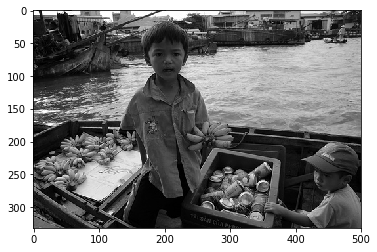

Decoded sentence:  a man is standing on a bench with a bench 

should be: ['\t', 'the', 'young', 'boy', 'is', 'selling', 'various', 'kinds', 'of', 'foods', '\n']
-
Input


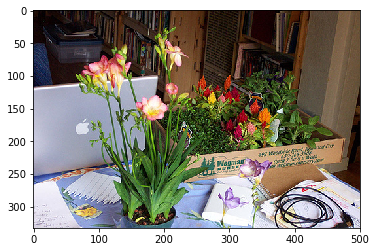

Decoded sentence:  a table sitting on a table with a table 

should be: ['\t', 'a', 'close', 'up', 'of', 'a', 'pot', 'of', 'flowers', 'with', 'a', 'box', 'of', 'flowers', '\n']
-
Input


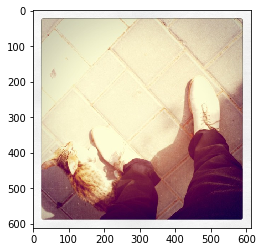

Decoded sentence:  a cat is sitting on a table with a table 

should be: ['\t', 'the', 'camera', 'person', 'is', 'wearing', 'white', 'tennis', 'shoes', 'out', 'on', 'the', 'patio', '\n']
-
Input


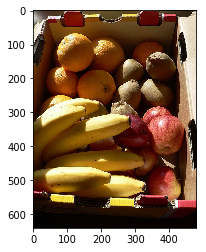

Decoded sentence:  a large abundance with a farmers a farmers 

should be: ['\t', 'a', 'brown', 'cardboard', 'box', 'filled', 'with', 'bananas', 'apples', 'oranges', 'and', 'kiwis', '\n']
-
Input


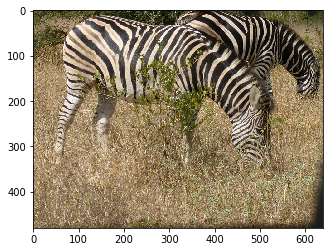

Decoded sentence:  a zebra standing in a grass in the field 

should be: ['\t', 'two', 'zebras', 'that', 'are', 'standing', 'in', 'the', 'grass', '\n']
-
Input


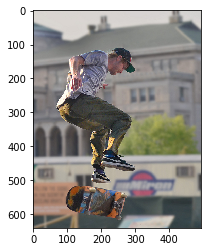

Decoded sentence:  a man is jumping to a skateboard in the skateboard 

should be: ['\t', 'a', 'young', 'man', 'is', 'in', 'the', 'air', 'and', 'working', 'on', 'a', 'trick', '\n']
-
Input


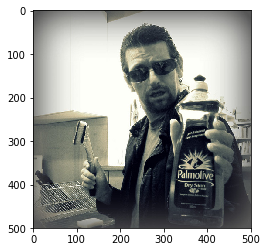

Decoded sentence:  a man is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is
should be: ['\t', 'man', 'in', 'kitchen', 'holding', 'dish', 'washing', 'soap', 'and', 'brush', '\n']
-
Input


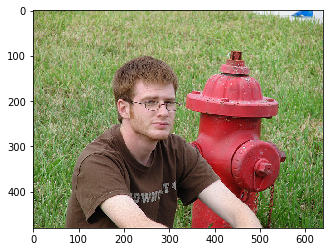

Decoded sentence:  a man standing in a grass in a field 

should be: ['\t', 'a', 'man', 'sitting', 'in', 'the', 'grass', 'next', 'to', 'a', 'fire', 'hydrant', '\n']
-
Input


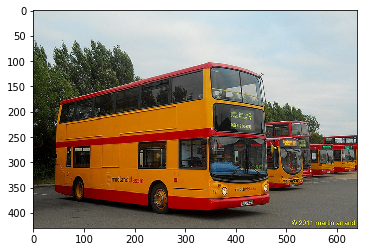

Decoded sentence:  a large bus is driving down a street 

should be: ['\t', 'a', 'double', 'deckered', 'bus', 'parked', 'in', 'a', 'parking', 'lot', '\n']
-
Input


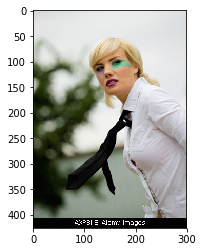

Decoded sentence:  a man holding a apple in a tie 

should be: ['\t', 'a', 'blonde', 'woman', 'in', 'a', 'necktie', 'is', 'wearing', 'colorful', 'makeup', '\n']
-
Input


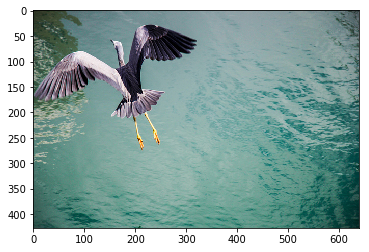

Decoded sentence:  a man standing on a snow of a snow 

should be: ['\t', 'a', 'large', 'long', 'winged', 'bird', 'flying', 'over', 'the', 'water', '\n']
-
Input


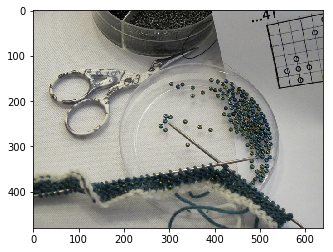

Decoded sentence:  a pair of scissors and a computer with a computer 

should be: ['\t', 'a', 'plate', 'of', 'crafting', 'beads', 'next', 'to', 'scissors', 'and', 'a', 'knitting', 'needle', '\n']
-
Input


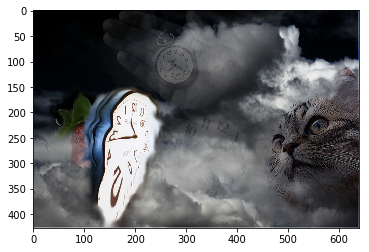

Decoded sentence:  a pigeon is standing on a beach in the beach 

should be: ['\t', 'a', 'cat', 'floating', 'in', 'the', 'clouds', 'next', 'to', 'a', 'couple', 'of', 'clock', '\n']
-
Input


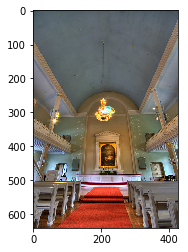

Decoded sentence:  a large clock is sitting on a ceiling 

should be: ['\t', 'a', 'set', 'of', 'chair', 'sin', 'a', 'small', 'white', 'church', '\n']
-
Input


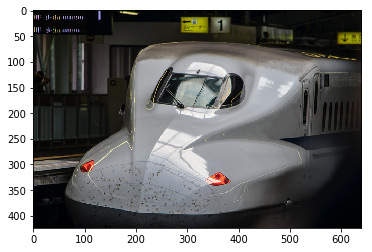

Decoded sentence:  a train is sitting on a bathroom with a table 

should be: ['\t', 'an', 'odd', 'white', 'subway', 'car', 'with', 'spots', 'on', 'the', 'front', '\n']
-
Input


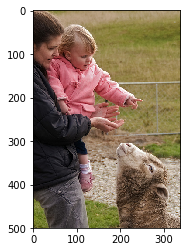

Decoded sentence:  a man standing in a field with a frisbee 

should be: ['\t', 'a', 'person', 'holding', 'a', 'little', 'girl', 'next', 'to', 'a', 'sheep', '\n']
-
Input


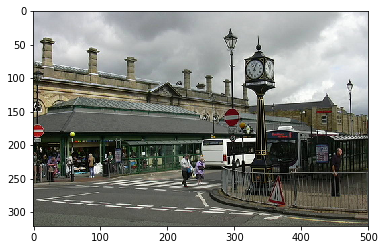

Decoded sentence:  a large white and white and white and white truck 

should be: ['\t', 'a', 'traffic', 'intersection', 'with', 'pedestrians', 'walking', 'on', 'the', 'sidewalk', '\n']
-
Input


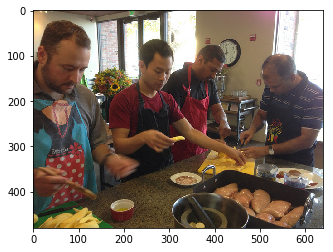

Decoded sentence:  a man sitting on a table with a table 

should be: ['\t', 'a', 'group', 'of', 'people', 'standing', 'around', 'a', 'table', 'preparing', 'food', '\n']
-
Input


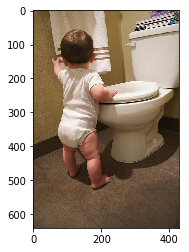

Decoded sentence:  a man is standing in a toilet with a toilet 

should be: ['\t', 'a', 'baby', 'standing', 'in', 'front', 'of', 'a', 'white', 'toilet', '\n']
-
Input


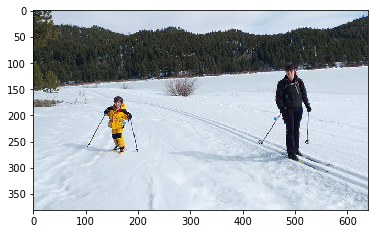

Decoded sentence:  a man skiing down a snow with a snow 

should be: ['\t', 'a', 'man', 'and', 'young', 'boy', 'cross', 'country', 'ski', 'in', 'a', 'snow', 'covered', 'field', '\n']
-
Input


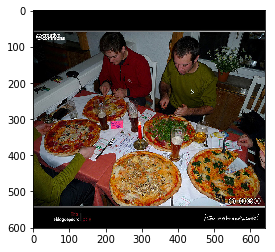

Decoded sentence:  a group of people are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are are
should be: ['\t', 'a', 'group', 'of', 'friends', 'siting', 'at', 'a', 'table', 'enjoying', 'pizza', '\n']
-
Input


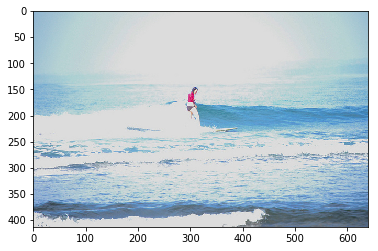

Decoded sentence:  a man standing on a beach with a beach 

should be: ['\t', 'a', 'woman', 'in', 'a', 'red', 'shirt', 'surfing', 'a', 'wave', '\n']
-
Input


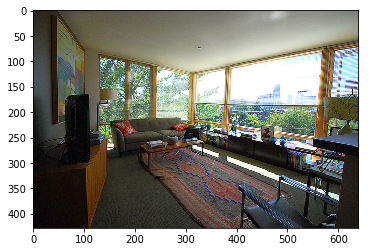

Decoded sentence:  a living room with a room with a room 

should be: ['\t', 'a', 'living', 'room', 'filled', 'with', 'a', 'large', 'rug', 'and', 'furniture', '\n']
-
Input


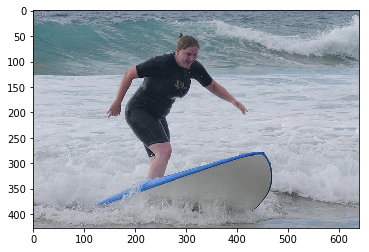

Decoded sentence:  a person is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is
should be: ['\t', 'a', 'woman', 'in', 'black', 'wetsuit', 'on', 'a', 'blue', 'and', 'white', 'surfboard', '\n']
-
Input


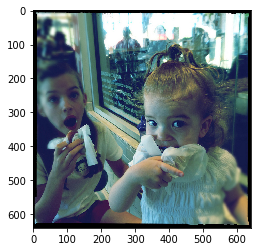

Decoded sentence:  a man holding to a phone and a phone 

should be: ['\t', 'two', 'little', 'girls', 'are', 'enjoying', 'their', 'ice', 'cream', 'treats', '\n']
-
Input


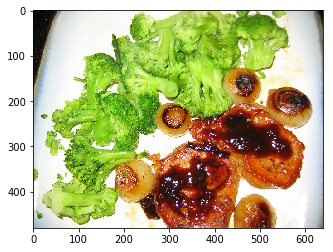

Decoded sentence:  a plate of a sandwich and a sandwich 

should be: ['\t', 'a', 'white', 'plate', 'topped', 'with', 'meat', 'and', 'broccoli', '\n']
-
Input


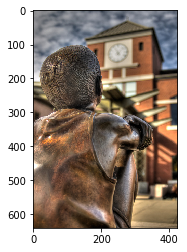

Decoded sentence:  a man is standing on a bench in the bench 

should be: ['\t', 'a', 'bronze', 'statue', 'of', 'a', 'boy', 'sits', 'while', 'looking', 'toward', 'a', 'brick', 'building', 'with', 'a', 'large', 'clock', 'on', 'the', 'side', '\n']
-
Input


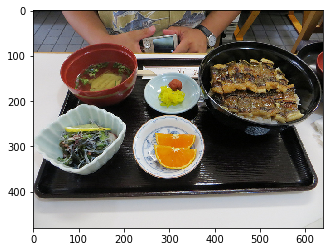

Decoded sentence:  a table and a plate of a sandwich and a bowl 

should be: ['\t', 'a', 'tray', 'that', 'has', 'different', 'plates', 'and', 'bowls', 'on', 'it', '\n']
-
Input


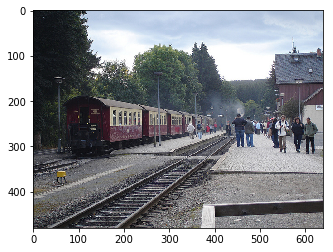

Decoded sentence:  a train is is is is is is traveling on a train 

should be: ['\t', 'a', 'train', 'on', 'a', 'track', 'beside', 'a', 'small', 'village', '\n']
-
Input


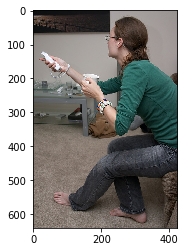

Decoded sentence:  a man standing in a room with a wii 

should be: ['\t', 'a', 'person', 'sitting', 'in', 'a', 'living', 'room', 'playing', 'nintendo', 'wii', '\n']
-
Input


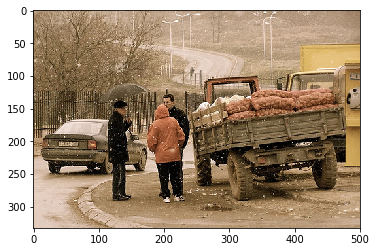

Decoded sentence:  a man is standing on a street with a street 

should be: ['\t', 'an', 'umbrella', 'isnt', 'usually', 'used', 'during', 'snow', 'flurries', '\n']
-
Input


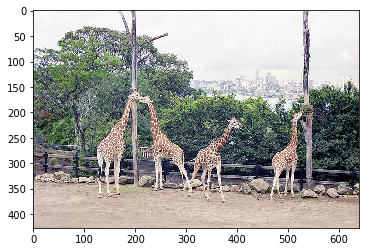

Decoded sentence:  a group of giraffes standing in a elephant 

should be: ['\t', 'four', 'giraffe', 'are', 'standing', 'close', 'to', 'a', 'wooden', 'fence', '\n']


In [22]:
def decode(code,seq,seq_index,sentence):
    decode_token_index=np.argmax(model.predict([code,seq])[0])
    seq[0][seq_index]=decode_token_index
    if decode_token_index==0:
        sampled_char=' '
        #print("Sampled:",decode_token_index," ")
    else:
        sampled_char=detoken[decode_token_index]
        #print("Sampled:",decode_token_index,sampled_char)
    sentence+=(" "+sampled_char)
    if seq_index+1==seq_len or sampled_char=='\n':
        return sentence
    else:
        return decode(code,seq,seq_index+1,sentence)
    
indices=random.sample(range(len(train_x_file)),32)
for index in indices:
    code=vggextract(train_x_file[index])
    code=np.reshape(code,(1,code.shape[0]))
    did=np.zeros(
        (seq_len),dtype='float32'
    )
    did=np.reshape(did,(1,did.shape[0]))
    did[0][0]=float(token['\t'])
    sentence=decode(code,did,1,"")
    print("-")
    print("Input")
    plt.imshow(np.asarray(Image.open(train_x_file[index])))
    plt.show()
    print("Decoded sentence:",sentence)
    print("should be:",train_y_seq[index])